In [23]:
from pybaseball import schedule_and_record
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)

REFRESH_DATA = 1
DATA_DIR = "2024_mlb_team_game_logs"

First we define the list of MLB teams by three letter code on baseball-reference.com

In [24]:
mlb_teams = [
    "BAL", "BOS", "CHW", "CLE", "DET", "HOU", "KC", "LAA", "MIN", "NYY", "OAK", "SEA", "TBR", "TEX", "TOR",
    "ARI", "ATL", "CHC", "CIN", "COL", "MIA", "MIL", "NYM", "PHI", "PIT", "SDP", "SFG", "STL", "WSN"
]

Next, we pull down fresh data locally to work with but only if we set REFRESH_DATA to True.

In [25]:
if REFRESH_DATA == 1:
    for team in mlb_teams:
        data = schedule_and_record(2024, team)
        data.to_csv(f"{DATA_DIR}/{team}.csv", sep=',', encoding="utf-8")

http://www.baseball-reference.com/teams/BAL/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/BOS/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/CHW/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/CLE/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/DET/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/HOU/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/KC/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/LAA/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/MIN/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/NYY/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/OAK/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/SEA/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/TBR/2024-schedule-scores.shtml
http://www.baseball-reference.com/teams/TEX/2024-schedule-scores.shtml
http://

After, we read the databack in and prepare to shape it for our analysis

In [26]:

path = f'{DATA_DIR}/' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

Drop all unceessary columns for our data application.

In [27]:
df = df.drop(columns=["Unnamed: 0", "GB", "Win", "Opp", "Loss", "RA", "Save", "W-L", "W/L", "D/N", "cLI", "Streak","Rank", "Inn", "Orig. Scheduled"])

Locate all the duplicate entries since this is the output for all teams.

In [28]:
duplicates = df[df.duplicated(subset=['Date', 'Attendance'])]

Now that we have our duplicate fields, we need to rename them and get them ready to merge back into `df`

In [29]:
master_set = pd.merge(df, duplicates, how="outer", on=["Attendance", "Date", "Time"])
master_set.shape

(10416, 9)

Perform cleanup actions on the newly merged data set.

In [30]:
master_set.drop(master_set.index[master_set['Tm_x'] == master_set['Tm_y']], inplace=True)
master_set = master_set.dropna(subset=["Attendance"])

master_set['Total_Runs'] = master_set['R_x'] + master_set['R_y']

master_set = master_set[['Date', 'Tm_x', 'Home_Away_x', 'R_x', 'Tm_y', 'Home_Away_y', 'R_y', 'Total_Runs', 'Time', 'Attendance']]
master_set = master_set.sort_values(by=['Date'])
master_set = master_set.reset_index(drop=True)

Now that's great, lets create some graphs

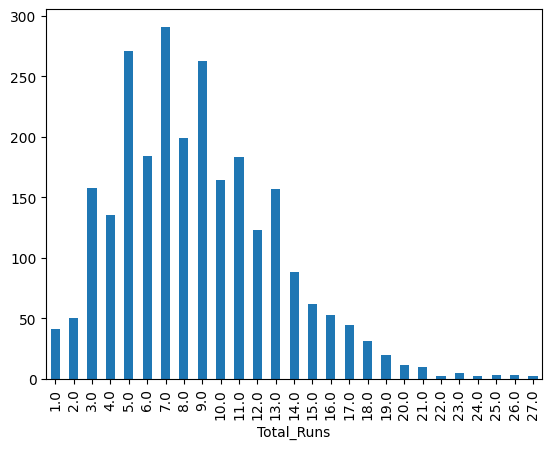

In [31]:

ax = master_set['Total_Runs'].value_counts()
ax = ax.sort_index()
ax = ax.plot(kind='bar')

At this point, we have enough data to determine what number of games have ended in each number of total runs. 

We will use the data to determine what we should statistically be betting in the Total Runs market (the over/under).

In [32]:

total_games = 2502
for n in range(1, 28):
    games = sqldf(f'''SELECT COUNT(*) from master_set WHERE Total_Runs <= {n}''').iloc[0,0]
    #print(f"for less than or equal to {n} runs the amount of games were: {games.iloc[0,0]} ")
    print(f"Percentage of games {n} runs or less: {((games/total_games)* 100):.2f}%")

for n in range(1, 28):
    games = sqldf(f'''SELECT COUNT(*) from master_set WHERE Total_Runs >= {n}''').iloc[0,0]
    #print(f"for greater than or equal to {n} runs the amount of games were: {games.iloc[0,0]} ")
    print(f"Percentage of games {n} runs or more: {((games/total_games)* 100):.2f}%")

Percentage of games 1 runs or less: 1.64%
Percentage of games 2 runs or less: 3.64%
Percentage of games 3 runs or less: 9.95%
Percentage of games 4 runs or less: 15.35%
Percentage of games 5 runs or less: 26.18%
Percentage of games 6 runs or less: 33.53%
Percentage of games 7 runs or less: 45.16%
Percentage of games 8 runs or less: 53.12%
Percentage of games 9 runs or less: 63.63%
Percentage of games 10 runs or less: 70.18%
Percentage of games 11 runs or less: 77.50%
Percentage of games 12 runs or less: 82.41%
Percentage of games 13 runs or less: 88.69%
Percentage of games 14 runs or less: 92.21%
Percentage of games 15 runs or less: 94.68%
Percentage of games 16 runs or less: 96.80%
Percentage of games 17 runs or less: 98.56%
Percentage of games 18 runs or less: 99.80%
Percentage of games 19 runs or less: 100.60%
Percentage of games 20 runs or less: 101.04%
Percentage of games 21 runs or less: 101.44%
Percentage of games 22 runs or less: 101.52%
Percentage of games 23 runs or less: 101

In this case, we can now identify the threshold of games where over half of games result in a certain amount of runs. At the time of this run, it appears betting the under for 9 RPG would result in a 51% edge. Lets model what this would look like betting at certain odds. 

In [33]:
odds_l = 100
odds_h = 110
stake = 1
bankroll = 500
total_games = 2502

for n in range(1, 28):
    games = sqldf(f'''SELECT COUNT(*) from master_set WHERE Total_Runs <= {n}''').iloc[0,0]   
    print(f"Percentage of games {n} runs or less: {((games/total_games)* 100):.2f}%")

    for x in range(1, games):
        rand_odds = random.randint(odds_l, odds_h)
        payout = (stake * rand_odds) / 100
        bankroll = bankroll + payout
    
    print(f"The resulting bankroll for odds at {odds} and a stake of {stake} over {total_games} games: {bankroll:.2f}")  

# for n in range(1, 28):
#     games = sqldf(f'''SELECT COUNT(*) from master_set WHERE Total_Runs >= {n}''').iloc[0,0]
#     #print(f"for greater than or equal to {n} runs the amount of games were: {games.iloc[0,0]} ")
#     print(f"Percentage of games {n} runs or more: {((games/total_games)* 100):.2f}%")


Percentage of games 1 runs or less: 1.64%


NameError: name 'odds' is not defined

In [271]:
master_set.to_csv(f'master_set.csv', sep=',', encoding='utf-8')